In [1]:
import sys
sys.path.append('../')

import torch
import matplotlib.pyplot as plt

device = torch.device('cpu')
_ = torch.set_grad_enabled(False)

from lib.models.gan import Generator
from lib.functional.sampling import generate_random_input
from lib.functional.interpolation import get_interpolation
from lib.functional.renderer.render import run_rendering

In [2]:
### You might enconter the error in the "torchgeometry" library. 
### It can be fixed following the solution here:
### https://stackoverflow.com/questions/65637222/runtimeerror-subtraction-the-operator-with-a-bool-tensor-is-not-supported

### The following snippet must be put in 
### {ANACONDA_HOME}/envs/supp/lib/python3.8/site-packages/torchgeometry/core/conversions.py 
### (in function rotation_matrix_to_quaternion, around line 300) :
### replace
# mask_c1 = mask_d2 * (1 - mask_d0_d1)
# mask_c2 = (1 - mask_d2) * mask_d0_nd1
# mask_c3 = (1 - mask_d2) * (1 - mask_d0_nd1)

### with
# mask_c1 = mask_d2 * ~(mask_d0_d1)
# mask_c2 = ~(mask_d2) * mask_d0_nd1
# mask_c3 = (~(mask_d2)) * (~(mask_d0_nd1))

In [3]:
### load the model
latent_size = 32
num_joints = 21
net = Generator(latentD=latent_size, num_joints=num_joints)

ckpt = './../gan_s_pretrained_state_dict.pth' # path to pretrained generative model
ckpt = torch.load(ckpt, map_location='cpu')
net.load_state_dict(ckpt)
net.eval()
net = net.to(device)

In [4]:
### sample random latent points
seed = 1234
torch.manual_seed(seed)
batch_size = 64
z = generate_random_input(batch_size, latent_size, latent_space_type='S', device=device)
print(z.shape)

torch.Size([64, 32])


In [5]:
### obtain the body poses
poses = net(z.view(-1,latent_size), output_type='aa').view(-1, num_joints*3) # batch_size x 3*num_joints
print(poses.shape)

### construct SMPL inputs
betas = torch.zeros(len(poses), 16).to(device)
smpl_vec = torch.cat((poses, betas), dim=1)
print(smpl_vec.shape)

torch.Size([64, 63])
torch.Size([64, 79])


In [6]:
### render images
img_size = 64 # small to make it work on CPU in a reasonable time (1024 was used in the paper)
batch_size_max = 20 # for CPU (~100 for GPU was used in the paper
path_to_smpl = './../data/smpl_neutral_lbs_10_207_0_v1.0.0.pkl'

images = run_rendering(smpl_vec, 
                       img_size=img_size, 
                       cam_distance=2.4, 
                       device=device, 
                       batch_size_max=batch_size_max, 
                       model_folder=path_to_smpl,
                       background_white=True)
print(images.shape)

20 out of  64
40 out of  64
60 out of  64
64 out of  64
(64, 64, 64, 3)


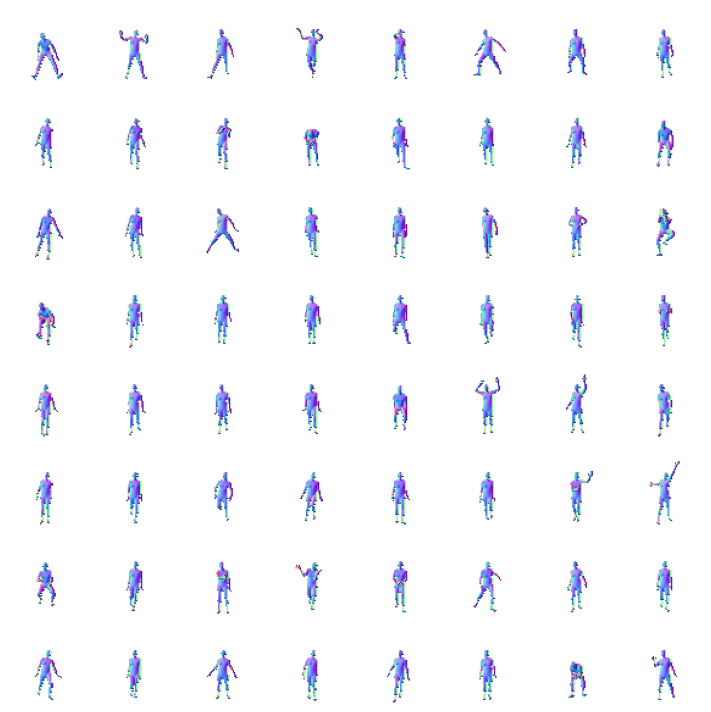

In [7]:
fig, ax = plt.subplots(8,8, figsize=(10,10))
ax = ax.flatten()
for img, axis in zip(images, ax):
    axis.imshow(img)
    axis.set_axis_off()
fig.tight_layout()